# Predict Bike Sharing Demand with AutoGluon

## Step 1: Download the Kaggle dataset using the kaggle python library

### Install packages

In [2]:
!pip install -q Kaggle
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Import Modules

In [3]:
import pandas as pd
from autogluon.tabular import TabularPredictor

### Setup Kaggle API Key

In [4]:
# make sure the kaggle.json file (Kaggle API Key) is in the same directory as the jupyter notebook
!mkdir ~/.kaggle # run only once
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### Download and explore dataset

In [5]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

  0%|                                                | 0.00/189k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 189k/189k [00:00<00:00, 72.3MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [11]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv')
train['datetime'] = pd.to_datetime(train['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [12]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454


In [13]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv')
test['datetime'] = pd.to_datetime(test['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [14]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv')
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 2: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [15]:
columns_to_drop = ['casual','registered']
train = train.drop(columns=columns_to_drop)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


In [16]:
predictor = TabularPredictor(
    label="count", problem_type="regression", eval_metric="root_mean_squared_error"
).fit(
    train_data=train, time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20240430_215943"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240430_215943"
AutoGluon Version:  0.8.2
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Mar 23 09:49:55 UTC 2024
Disk Space Avail:   106.41 GB / 107.32 GB (99.2%)
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
/opt/conda/lib/python3.10/site-packages/autogluon/tabular/learner/default_learner.py:215: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Using Feature Generators to preprocess the dat

### Review AutoGluon's training run with ranking of models that did the best.

In [17]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                    model   score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L3  -52.730199       4.580989  68.511571                0.000648           0.237464            3       True          8
1  RandomForestMSE_BAG_L2  -53.309378       3.612954  56.981679                0.973129          31.658133            2       True          6
2    ExtraTreesMSE_BAG_L2  -53.451431       3.607213  36.615974                0.967387          11.292428            2       True          7
3   KNeighborsDist_BAG_L1  -84.125061       0.069127   0.032427                0.069127           0.032427            1       True          2
4     WeightedEnsemble_L2  -84.125061       0.069938   0.345542                0.000811           0.313115            2       True          5
5   KNeighborsUnif_BAG_L1 -101.546199       0.044933   0.041852                0.04493

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'RandomForestMSE_BAG_L1': -116.54835939455667,
  'ExtraTreesMSE_BAG_L1': -124.60067564699747,
  'WeightedEnsemble_L2': -84.12506123181602,
  'RandomForestMSE_BAG_L2': -53.30937847291498,
  'ExtraTreesMSE_BAG_L2': -53.45143074386139,
  'WeightedEnsemble_L3': -52.730199076200954},
 'model_best': 'WeightedEnsemble_L3',
 'model_paths': {'KNeighborsUnif_BAG_L1': ['KNeighborsUnif_BAG_L1'],
  'KNeighborsDist_BAG_L1': ['KNeighborsDist_BAG_L1'],

<Axes: xlabel='model'>

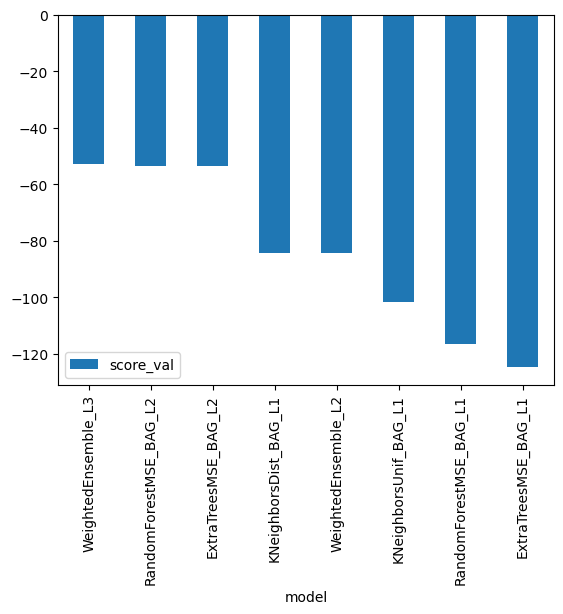

In [18]:
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

### Create predictions from test dataset

In [19]:
predictions = predictor.predict(test)
predictions.head()

0    22.444073
1    41.671574
2    45.626762
3    46.568428
4    50.585464
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [20]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.191887
std        90.330627
min         2.130000
25%        19.085648
50%        62.764816
75%       169.132050
max       358.224182
Name: count, dtype: float64

In [21]:
# How many negative values do we have?
num_negatives = (predictions < 0).sum().sum()
num_negatives

0

In [ ]:
# Set them to zero
?

### Set predictions to submission dataframe, save, and submit

In [22]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [23]:
#!pip install -q Kaggle
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 693kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [24]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv               2024-04-30 22:03:08  first raw submission  complete  1.84007      1.84007       
submission_new_features.csv  2024-04-30 18:43:56  new features          complete  1.80125      1.80125       
submission.csv               2024-04-30 18:14:18  first raw submission  complete  1.80125      1.80125       
submission.csv               2024-04-30 17:06:26  first raw submission  complete  1.80549      1.80549       


#### Initial score of `1.84007`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'holiday'}>],
       [<Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'weather'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'count'}>, <Axes: >, <Axes: >]],
      dtype=object)

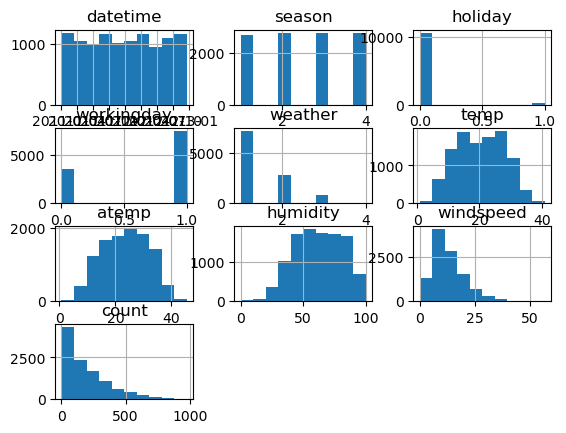

In [25]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist()

In [26]:
# create a new feature
train['hour'] = train['datetime'].dt.hour
test['hour'] = test['datetime'].dt.hour

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [27]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [28]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4


array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'workingday'}>],
       [<Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>],
       [<Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'count'}>,
        <Axes: title={'center': 'hour'}>]], dtype=object)

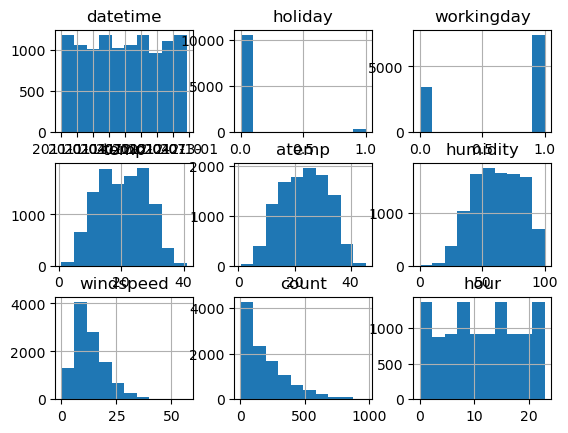

In [29]:
# View histogram of all features again now with the hour feature
train.hist()

## Step 5: Rerun the model with the same settings as before, just with more features

In [30]:
predictor_new_features = TabularPredictor(
    label="count", problem_type="regression", eval_metric="root_mean_squared_error"
).fit(
    train_data=train, time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20240430_220442"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240430_220442"
AutoGluon Version:  0.8.2
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Mar 23 09:49:55 UTC 2024
Disk Space Avail:   105.26 GB / 107.32 GB (98.1%)
Train Data Rows:    10886
Train Data Columns: 10
Label Column: count
Preprocessing data ...
/opt/conda/lib/python3.10/site-packages/autogluon/tabular/learner/default_learner.py:215: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Using Feature Generators to preprocess the da

In [31]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                    model   score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L3  -33.592543       3.299652  77.606874                0.000701           0.171905            3       True          8
1    ExtraTreesMSE_BAG_L2  -33.597649       2.504705  43.004795                0.754956          13.861317            2       True          7
2  RandomForestMSE_BAG_L2  -34.305692       2.543994  63.573653                0.794245          34.430175            2       True          6
3     WeightedEnsemble_L2  -37.031092       1.693937  29.444839                0.000862           0.373115            2       True          5
4    ExtraTreesMSE_BAG_L1  -38.326129       0.891376   9.008976                0.891376           9.008976            1       True          4
5  RandomForestMSE_BAG_L1  -38.454338       0.744243  20.017038                0.74424

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'RandomForestMSE_BAG_L1': -38.4543378929385,
  'ExtraTreesMSE_BAG_L1': -38.326129123608844,
  'WeightedEnsemble_L2': -37.03109233142706,
  'RandomForestMSE_BAG_L2': -34.3056917253308,
  'ExtraTreesMSE_BAG_L2': -33.597648669126336,
  'WeightedEnsemble_L3': -33.59254268898028},
 'model_best': 'WeightedEnsemble_L3',
 'model_paths': {'KNeighborsUnif_BAG_L1': ['KNeighborsUnif_BAG_L1'],
  'KNeighborsDist_BAG_L1': ['KNeighborsDist_BAG_L1'],
  

<Axes: xlabel='model'>

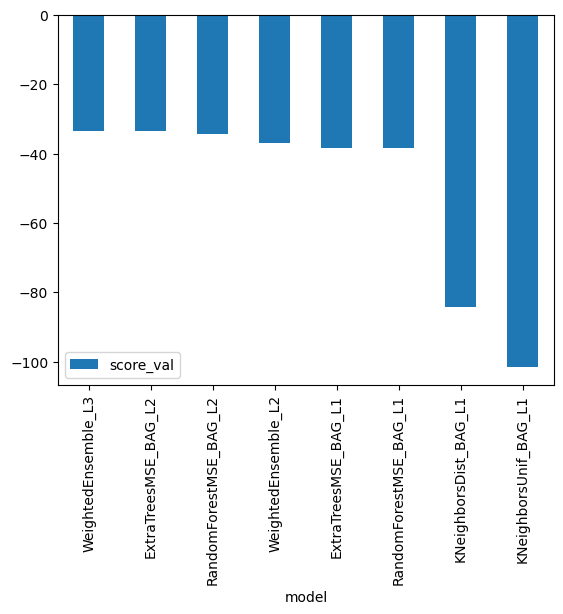

In [32]:
predictor_new_features.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

In [33]:
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features.head()

0    17.752186
1    11.594000
2     9.494111
3     4.669259
4     3.002185
Name: count, dtype: float32

In [34]:
predictions_new_features.describe()

count    6493.000000
mean      167.053833
std       144.843018
min         2.229370
25%        52.614628
50%       133.054138
75%       237.970627
max       861.925476
Name: count, dtype: float64

In [35]:
# Remember to set all negative values to zero
num_negatives = (predictions_new_features < 0).sum().sum()
num_negatives

0

In [36]:
submission_new_features = pd.read_csv('sampleSubmission.csv')
submission_new_features.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [37]:
# Same submitting predictions
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [38]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 628kB/s]
Successfully submitted to Bike Sharing Demand

In [39]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features.csv  2024-04-30 22:07:49  new features          complete  0.65378      0.65378       
submission.csv               2024-04-30 22:03:08  first raw submission  complete  1.84007      1.84007       
submission_new_features.csv  2024-04-30 18:43:56  new features          complete  1.80125      1.80125       
submission.csv               2024-04-30 18:14:18  first raw submission  complete  1.80125      1.80125       


#### New Score of `0.65378`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [47]:
hyperparameters = {
    'RF': {'n_estimators': 100, 'max_depth': 10},
    'KNN': {'n_neighbors': 5, 'weights': 'uniform'}
}

predictor_new_hpo = TabularPredictor(
    label="count", problem_type="regression", eval_metric="root_mean_squared_error"
).fit(
    train_data=train, time_limit=600, presets="best_quality", hyperparameters=hyperparameters)

No path specified. Models will be saved in: "AutogluonModels/ag-20240430_231520"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240430_231520"
AutoGluon Version:  0.8.2
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Mar 23 09:49:55 UTC 2024
Disk Space Avail:   104.13 GB / 107.32 GB (97.0%)
Train Data Rows:    10886
Train Data Columns: 10
Label Column: count
Preprocessing data ...
/opt/conda/lib/python3.10/site-packages/autogluon/tabular/learner/default_learner.py:215: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Using Feature Generators to preprocess the da

In [48]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model   score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  RandomForest_BAG_L2  -38.657331       0.333293  8.261415                0.123829           4.613522            2       True          4
1  WeightedEnsemble_L3  -38.657331       0.334349  8.268569                0.001056           0.007154            3       True          5
2  WeightedEnsemble_L2  -44.958448       0.209994  3.783843                0.000530           0.135950            2       True          3
3  RandomForest_BAG_L1  -45.450171       0.148765  3.609614                0.148765           3.609614            1       True          2
4    KNeighbors_BAG_L1 -101.546199       0.060699  0.038278                0.060699           0.038278            1       True          1
Number of models trained: 5
Types of models trained:
{'StackerEnsembleModel_RF', 'WeightedEnsembleModel', 'Sta

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighbors_BAG_L1': 'StackerEnsembleModel_KNN',
  'RandomForest_BAG_L1': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'RandomForest_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighbors_BAG_L1': -101.54619908446061,
  'RandomForest_BAG_L1': -45.45017142299662,
  'WeightedEnsemble_L2': -44.95844775882192,
  'RandomForest_BAG_L2': -38.65733071037285,
  'WeightedEnsemble_L3': -38.65733071037285},
 'model_best': 'WeightedEnsemble_L3',
 'model_paths': {'KNeighbors_BAG_L1': ['KNeighbors_BAG_L1'],
  'RandomForest_BAG_L1': ['RandomForest_BAG_L1'],
  'WeightedEnsemble_L2': ['WeightedEnsemble_L2'],
  'RandomForest_BAG_L2': ['RandomForest_BAG_L2'],
  'WeightedEnsemble_L3': ['WeightedEnsemble_L3']},
 'model_fit_times': {'KNeighbors_BAG_L1': 0.03827834129333496,
  'RandomForest_BAG_L1': 3.609614372253418,
  'WeightedEnsemble_L2': 0.13594985008239746,
  'RandomForest_BAG_L2': 4.613

<Axes: xlabel='model'>

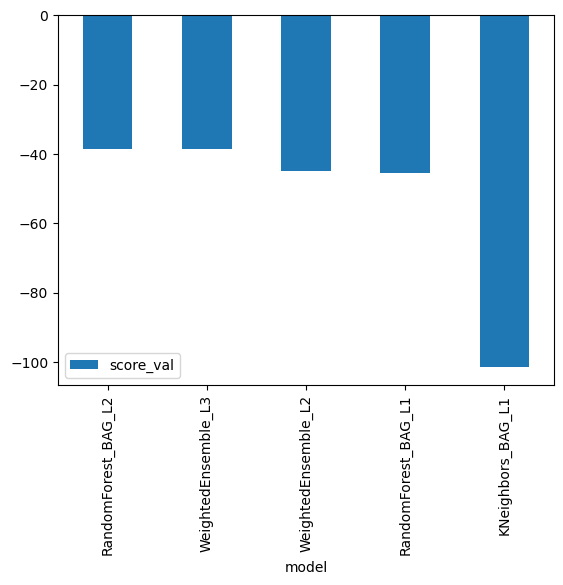

In [49]:
predictor_new_hpo.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

In [51]:
predictions_new_hpo = predictor_new_hpo.predict(test)
predictions_new_hpo.head()

0    36.046394
1     5.975618
2     3.658128
3     2.663388
4     2.579322
Name: count, dtype: float32

In [52]:
predictions_new_hpo.describe()

count    6493.000000
mean      161.895660
std       145.192902
min         2.235567
25%        42.299969
50%       126.631691
75%       231.284210
max       765.119507
Name: count, dtype: float64

In [53]:
# Remember to set all negative values to zero
num_negatives = (predictions_new_hpo < 0).sum().sum()
num_negatives

0

In [54]:
submission_new_hpo = pd.read_csv('sampleSubmission.csv')
submission_new_hpo.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [55]:
# Same submitting predictions
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [56]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 750kB/s]
Successfully submitted to Bike Sharing Demand

In [57]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2024-04-30 23:26:35  new features with hyperparameters  complete  0.57164      0.57164       
submission_new_features.csv  2024-04-30 22:07:49  new features                       complete  0.65378      0.65378       
submission.csv               2024-04-30 22:03:08  first raw submission               complete  1.84007      1.84007       
submission_new_features.csv  2024-04-30 18:43:56  new features                       complete  1.80125      1.80125       


#### New Score of `0.57164`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

In [ ]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [?, ?, ?]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

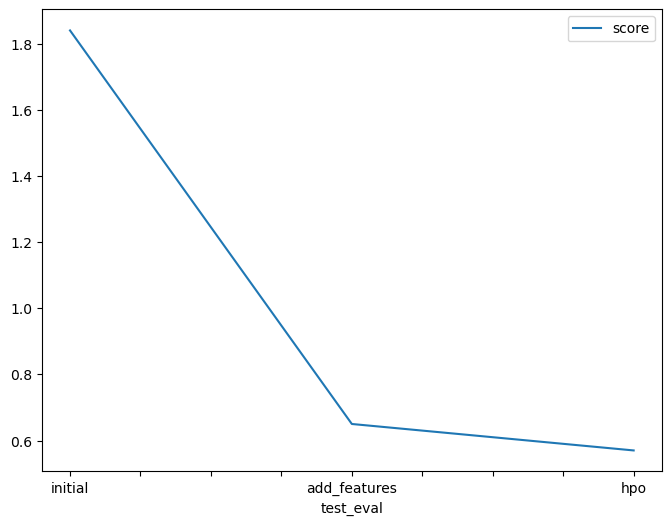

In [59]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.84, 0.65, 0.57]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [62]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "time_limit": [600, 600, 600],
    "presets": ['best quality', 'best quality', 'best quality'],
    "n_estimators(RF)": ['default', 'default', 100],
    "score": [1.84, 0.65, 0.57]
})

,model,time_limit,presets,n_estimators(RF),score
0,initial,600,best quality,default,1.84
1,add_features,600,best quality,default,0.65
2,hpo,600,best quality,100,0.57


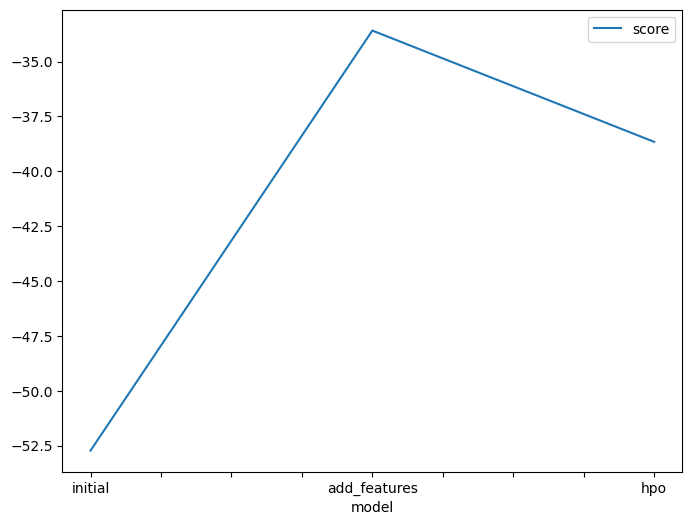

In [65]:
# Take the 3 top model scores and creating a line plot
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [-52.73, -33.59, -38.66]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')